In [1]:
import matplotlib.pyplot as plt
import random
import time
from functools import partial
from src import *

This class defined a directed random graph. It has edge probability of about 1/(2*nodes). This is enough that it isn't "sparse" but it probably isn't connected either.

In [2]:
class RandomGraph:
    def __init__(self, tb, n_nodes, n_edges):
        self.n_nodes = n_nodes
        self.n_edges = n_edges

        self.edge = functor("edge", 2)
        self.path = functor("path", 2)
        self.x, self.y, self.z = variables("xyz")

        self.tb = tb
        self.tb.tell(self.path(self.x, self.y) <= self.edge(self.x, self.y))
        self.tb.tell(self.path(self.x, self.y) <= self.edge(self.x, self.z) & self.path(self.z, self.y))

        self.random_edges()

    def node(self, i):
        return Term(f"node_{i}")

    def random_edges(self):
        for _ in range(self.n_edges):
            self.tb.tell(self.edge(
                self.node(random.randint(0, self.n_nodes)),
                self.node(random.randint(0, self.n_nodes))
            ))

In [3]:
g = RandomGraph(LinearTable(), 10, 10)

We can compare the different inference algorithms by looking at how
well they perform at graph path finding.

In [4]:
def path_search_comparison(algos, names, nodes, runs=10):
    data = {}
    
    for ask, name in zip(algos, names):
        data[name] = []

        # each ask function does the same task
        random.seed(123)

        # look at graphs of different sizes
        for n in nodes:
            
            # each function gets the same treatment
            t = time.time()

            for _ in range(runs):

                # check a bunch of random possible paths
                graph = RandomGraph(LinearTable(), n, round((n**2)/n))
                a, b = graph.node(random.randint(0, n)), graph.node(random.randint(0, n))

                # figure out if there is a path
                try:
                    next(ask(graph.tb, graph.path(a, b)))
                except StopIteration:
                    pass

            data[name].append((time.time() - t)/runs)
    
    return data, nodes

def plot_path_search(*args, **kwargs):
    
    data, nodes = path_search_comparison(*args, **kwargs)
    
    for alg, times in data.items():
        plt.plot(nodes, times, label=alg)

    plt.title("Path Search in Semi-Dense Random Graph")
    plt.xlabel("graph size (nodes)")
    plt.ylabel("time (s)")
    plt.legend()

The best performers appear to be forward chaining and bounded backward chaining. These are both about to perform the traversal of graphs of up to 10 nodes in the approximately 1.5 sec of CPU I have before I get bored. The growth rate for fc appears to be much worse, but this might be a lie beacause the bound on the backward chaining here is 10 nodes, which is exactly right for the largest graph on this chart, with 10 nodes. It would likely also take a significant performace hit to scale to larger networks.

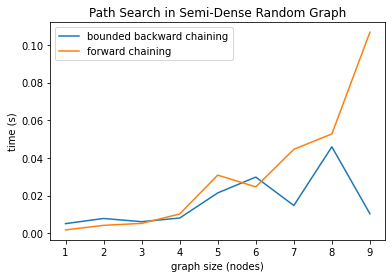

In [5]:
algos = [partial(bc_ask, patience=10), fc_ask, partial(id_ask, patience=10), bc_ask]
names = ["bounded backward chaining", "forward chaining", "iterative deepening", "backward chaining"]

plot_path_search(algos=algos[:2], names=names[:2], nodes=list(range(1, 10)))

Iterative deepening is worse by at least a large constant factor for small grpah sizes. How much worse? It's hard to tell from this graph, but enough to matter.

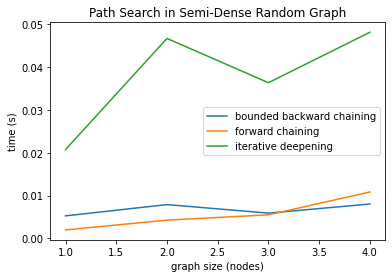

In [6]:
plot_path_search(algos[:3], names[:3], list(range(1, 5)))

If we include backward chaining, we can't even really run the program because it gets stuck. I expect this is because backwards chaining has a tendency to get "stuck" moving around and around on the same cycles but I am not sure.

In [7]:
plot_path_search(algos, names, list(range(1, 3)))

KeyboardInterrupt: 